# 3D reconstruction and display

In this notebook we are going to do 3D reconstruction for an small portion of video, or a considerable number of frames, using the weighted mean method, since we saw that maybe is the most consistent one. We will do it using just three cameras, since we do not think it helps a lot adding an extra one.

In [2]:
import json

number_keypoints = 25
number_frames = 1000

point1 = []
p1 = []
for i in range (number_frames):
# Subject 1
    with open('frames_experiments/3D_reconstruction/HC/HC_00000000{}_keypoints.json'.format(1519+i), 'r') as myfile:
        data=myfile.read()
    obj = json.loads(data)
    people = obj['people']
    if people[0]['pose_keypoints_2d'][0] < 640:
        p1 = people[0]['pose_keypoints_2d']
    else:
        p1 = people[1]['pose_keypoints_2d']
    p1 = [float(elem) for elem in p1]
    point1.append(p1)
    
point2 = []
p2 = []
for i in range (number_frames):
# Subject 1
    with open('frames_experiments/3D_reconstruction/N1/N1_00000000{}_keypoints.json'.format(1519+i), 'r') as myfile:
        data=myfile.read()   
    obj = json.loads(data)
    people = obj['people']
    p2 = [float(elem) for elem in people[0]['pose_keypoints_2d']]
    point2.append(p2)

point3 = []
p3 = []
for i in range (number_frames):
# Subject 1
    with open('frames_experiments/3D_reconstruction/Z1/Z1_00000000{}_keypoints.json'.format(1503+i), 'r') as myfile:
        data=myfile.read()        
    obj = json.loads(data)
    people = obj['people']
    p3 = [float(elem) for elem in people[0]['pose_keypoints_2d']]
    point3.append(p3)
    

## Discard ouliers

In [3]:
import cv2
import numpy as np

In [4]:
def error (reproj, orig):
    diff1 = abs(orig[0][0][0]-reproj[0][0][0])
    diff2 = abs(orig[0][0][1]-reproj[0][0][1])
    return [diff1, diff2]

def relative_error (reproj, orig):
    diff1 = abs(orig[0][0][0]-reproj[0][0][0])
    diff2 = abs(orig[0][0][1]-reproj[0][0][1])
    return (diff1*100/1280, diff2*100/720)

def extrinsic_inverse(M):
    N = np.identity(4)
    N[:3,:4] = M
    return np.linalg.inv(N)[:3,:4]

def extrinsic_mult(A,B):
    M = np.identity(4)
    N = np.identity(4)
    M[:3,:4] = A
    N[:3,:4] = B
    return np.dot(M,N)[:3,:4]


In [5]:
# Intrinsic matrices
I_HC = np.array([[1561.0879250519019, 0., 696.26643757458214], 
                 [0., 1559.8875934756718, 364.00150809603042], 
                 [0., 0., 1.]])
I_N1 = np.array([[1.5302606428953902e+03, 0., 6.3704463363410275e+02], 
                 [0., 1.5363325136178830e+03, 4.0223336660626796e+02], 
                 [0., 0., 1.]])
I_Z1 = np.array([[1.7186882095790779e+03, 0., 5.9860544121349926e+02], 
                 [0., 1.5403542389142547e+03, 3.8155238056391255e+02], 
                 [0., 0., 1.]])


# Extrinsic matrices
E_HC = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.]])
E_id = E_HC # matrix identity

E_N2HC = np.array([[4.7071373825592244e-01, -3.1599447001591768e-01, 8.2375728921600100e-01, -1.0304478556951631e+03],
                    [2.8802340986999736e-01, 9.3754663626875434e-01, 1.9506106784287736e-01, -3.0531267263949093e+02],
                    [-8.3394909436007802e-01, 1.4544345891274529e-01, 5.3232988670137815e-01, 9.1388342483064150e+02]])
E_N1N2 = np.array([[-5.4986998367568851e-01, 3.0581005268310585e-01, -7.7725363474894993e-01, 8.3663027029970908e+02],
                   [-2.2725644654053018e-01, 8.4068086603861980e-01, 4.9153859358378738e-01, -6.3514254777430710e+02],
                   [8.0373970199204992e-01, 4.4691821752364558e-01, -3.9276786819598442e-01, 1.8039039431233032e+03]])
E_N1Z1 = np.array([[9.7907944983707595e-01, 7.5806963742383632e-02, -1.8882991064682936e-01, 4.7378144665229661e+02], 
                   [-4.3073408183321484e-02, 9.8419391226508868e-01, 1.7177608846347608e-01, -3.6645021346744181e+02],
                   [1.9886707222212935e-01, -1.6004889036947406e-01, 9.6686929844591629e-01, 2.8227302985118314e+02]])

E_HCN2 = extrinsic_inverse(E_N2HC)
E_N2N1 = extrinsic_inverse(E_N1N2)

E_HCN1 = extrinsic_mult(E_N2N1, E_HCN2)
E_HCZ1 = extrinsic_mult(E_N1Z1, E_HCN1)


# Distortion parameters
k_HC = np.array([-3.6946481172355405e-01, 1.7682498387118720e-01, 0., 0., 0.])
k_N1 = np.array([-3.5111725250493975e-01, 1.5902320213719132e-01, 0., 0., 0.])
k_Z1 = np.array([-3.5841115333091467e-01, 1.1657468374802429e-01, 0., 0., 0.])

In [6]:
def discard_outliers(point1, point2, point3, I1, I2, I3, E1, E2, E3, k1, k2, k3, length, t):
    # We will set values to zero to the outliers
    new_point1 = point1.copy()
    new_point2 = point2.copy()
    new_point3 = point3.copy()
    
    for i in range(0,length,3):
        
        
        if point1[i] != 0 or point2[i] != 0 or point3[i] != 0:
            
            p1 = np.array([[[point1[i], point1[i+1]]]])
            p2 = np.array([[[point2[i], point2[i+1]]]])
            p3 = np.array([[[point3[i], point3[i+1]]]])
            
            projPoints1 = cv2.undistortPoints(p1, I1, k1)
            projPoints2 = cv2.undistortPoints(p2, I2, k2)
            projPoints3 = cv2.undistortPoints(p3, I3, k3)
            
            world_coord_12 = cv2.triangulatePoints(E1, E2, projPoints1, projPoints2) 
            world_coord_norm_12 = (world_coord_12[:-1]/world_coord_12[3]).reshape(1,1,3)
            world_coord_13 = cv2.triangulatePoints(E1, E3, projPoints1, projPoints3) 
            world_coord_norm_13 = (world_coord_13[:-1]/world_coord_13[3]).reshape(1,1,3)     
            world_coord_23 = cv2.triangulatePoints(E2, E3, projPoints2, projPoints3) 
            world_coord_norm_23 = (world_coord_23[:-1]/world_coord_23[3]).reshape(1,1,3)
            
            # This is for reprojection.
            R1 = E1[:3,:3]
            T1 = E1[:,3]
            R2 = E2[:3,:3]
            T2 = E2[:,3]
            R3 = E3[:3,:3]
            T3 = E3[:,3]
            
            # This array is to check which view is wrong, if there is
            error_view = np.array([0,0,0])
            
            reproj_2d_12_1 = cv2.projectPoints(world_coord_norm_12, R1, T1, I1, k1)[0]
            reproj_2d_12_2 = cv2.projectPoints(world_coord_norm_12, R2, T2, I2, k2)[0]
            if (error(reproj_2d_12_1, p1)[0] > t or error(reproj_2d_12_1, p1)[1] > t) and (error(reproj_2d_12_2, p2)[0] > t or error(reproj_2d_12_2, p2)[1] > t):
                error_view[0] = 1
                #This commented lines are to print the error and see it quantitatively
#                 print("\n Error HC: ", error(reproj_2d_12_1, p1))
#                 print(i, p1)
#                 print("\n Error N1: ", error(reproj_2d_12_2, p2))
#                 print(i, p2)

            
            reproj_2d_13_1 = cv2.projectPoints(world_coord_norm_13, R1, T1, I1, k1)[0]
            reproj_2d_13_2 = cv2.projectPoints(world_coord_norm_13, R3, T3, I3, k3)[0]
            if (error(reproj_2d_13_1, p1)[0] > t or error(reproj_2d_13_1, p1)[1] > t) and (error(reproj_2d_13_2, p3)[0] > t or error(reproj_2d_13_2, p3)[1] > t):
                error_view[1] = 1
#                 print("\n Error HC: ", error(reproj_2d_13_1, p1))
#                 print(i, p1)
#                 print("\n Error Z1: ", error(reproj_2d_13_2, p3))
#                 print(i, p3)
            
            reproj_2d_23_1 = cv2.projectPoints(world_coord_norm_23, R2, T2, I2, k2)[0]
            reproj_2d_23_2 = cv2.projectPoints(world_coord_norm_23, R3, T3, I3, k3)[0]
            if (error(reproj_2d_23_1, p2)[0] > t or error(reproj_2d_23_1, p2)[1] > t) and (error(reproj_2d_23_2, p3)[0] > t or error(reproj_2d_23_2, p3)[1] > t):
                error_view[2] = 1
#                 print("\n Error N1: ", error(reproj_2d_23_1, p2))
#                 print(i, p2)
#                 print("\n Error Z1: ", error(reproj_2d_23_2, p3))
#                 print(i, p3)
             

            if error_view.any(): # we enter here if error_view != (0,0,0). I will just consider an outlier if there are two 1's
                # I put three different if to set 0 the cases when just one point over the three views is detected. I put that
                # the points to be set to zero need to be different from zero because it is stupid to set 0 something that is
                # already 0
                if error_view[0] and error_view[1] and point1[i] != 0:
                    print("Error in view HC of the point {}".format(i/3))
                    new_point1[i] = 0.0
                    new_point1[i+1] = 0.0
                    new_point1[i+2] = 0.0
                if error_view[0] and error_view[2] and point2[i] != 0:
                    print("Error in view N1 of the point {}".format(i/3))
                    new_point2[i] = 0.0
                    new_point2[i+1] = 0.0
                    new_point2[i+2]= 0.0
                if error_view[1] and error_view[2] and point3[i] != 0:
                    print("Error in view Z1 of the point {}".format(i/3))
                    new_point3[i] = 0.0
                    new_point3[i+1] = 0.0
                    new_point3[i+2] = 0.0
                    
                    
    return new_point1, new_point2, new_point3

In [7]:
# We create three list of list to put the new_points
new_point1 = []
new_point2 = []
new_point3 = []
threshold = 15
for i in range(number_frames):
        print("Frame number {}".format(i+1))
        new_1, new_2, new_3=discard_outliers(point1[i], point2[i], point3[i], I_HC, I_N1, I_Z1, E_HC, E_HCN1, E_HCZ1, k_HC, k_N1, k_Z1, len(point1[i]), threshold)
        new_point1.append(new_1)
        new_point2.append(new_2)
        new_point3.append(new_3)
        print("\n")

Frame number 1
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view N1 of the point 9.0
Error in view Z1 of the point 9.0
Error in view HC of the point 12.0


Frame number 2
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view N1 of the point 9.0
Error in view Z1 of the point 9.0
Error in view HC of the point 12.0


Frame number 3
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view N1 of the point 9.0
Error in view Z1 of the point 9.0
Error in view HC of the point 12.0


Frame number 4
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view N1 of the point 9.0
Error in view Z1 of the point 9.0
Error in view HC of the point 12.0


Frame number 5
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view N1 of the point 9.0
Error in view Z1 of the point 9.0
Error in view HC of the point 12.0


Frame number 6
Error in view HC of the point 8.0
Error in vi

Error in view HC of the point 12.0
Error in view N1 of the point 18.0


Frame number 64
Error in view HC of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 18.0


Frame number 65
Error in view HC of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 18.0


Frame number 66
Error in view HC of the point 8.0
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 12.0
Error in view N1 of the point 18.0


Frame number 67
Error in view HC of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 18.0


Frame number 68
Error in view HC of the point 8.0
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 69
Error in view HC of the point 8.0
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 70
Error in view HC of the point 8.0
Error in 

Frame number 96
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 97
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 98
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 99
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 100
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 101
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 102
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 103
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 104
Error in view HC of the point 12.0


Frame number 105
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 106
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 107
Error in view HC of the point 8.0
Error in vi

Error in view HC of the point 12.0


Frame number 182
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 183
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 184
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 185
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 186
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 187
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 188
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 189
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 190
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 191
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 192
Error in view HC of the point 8.0


Frame number 193
Error in view

Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 260
Error in view HC of the point 12.0


Frame number 261
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 262
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 263


Frame number 264
Error in view HC of the point 12.0


Frame number 265
Error in view HC of the point 12.0


Frame number 266
Error in view HC of the point 8.0
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 267
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 268
Error in view HC of the point 12.0
Error in view N1 of the point 12.0


Frame number 269
Error in view HC of the point 12.0


Frame number 270
Error in view HC of the point 8.0
Error in view N1 of the point 



Frame number 403
Error in view HC of the point 17.0


Frame number 404
Error in view HC of the point 17.0


Frame number 405
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 12.0
Error in view Z1 of the point 12.0


Frame number 406
Error in view N1 of the point 0.0
Error in view N1 of the point 1.0
Error in view N1 of the point 2.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view N1 of the point 16.0
Error in view N1 of the point 18.0


Frame number 407
Error in view HC of the point 8.0
Error in view HC of the point 12.0


Frame number 408
Error in view HC of the point 12.0


Frame number 409
Error in view HC of the point 12.0


Frame number 410
Error in view HC of the point 12.0


Frame number 411
Error in view HC of the point 12.0
Error in view N1 of the point 12.0
Error in view Z1 of the point 12.0


Frame number 412
Error in view HC of the point 12.0
Error in view N1 of the point 12.0
Error in v

Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 479
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 480
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 481
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 482
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 483
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error

Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 553
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 554
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 555
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 556
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 557
Error in view N1 of the point 0.0
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error 

Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 633
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 634
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 635
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 636
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0
Error in view HC of the point 17.0


Frame number 637
Error in view HC of the point 8.0
Error in view Z1 of the point 8.0
Error in view HC of the point 12.0
Error



Frame number 717
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 718
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 719
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 720
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view N1 of the point 12.0
Error in view Z1 of the point 12.0


Frame number 721
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 722
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 723
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 724
Error in view N1 of the point 8.0
Error in view HC of the point 12.0
Error in view Z1 of the point 12.0


Frame number 725
Error in view N1 of the point 

Error in view N1 of the point 18.0
Error in view Z1 of the point 18.0


Frame number 797
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 798
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 799
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 800
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 801
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 802
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 803
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 804
Error in view HC of the point 8.0
Error in view HC of the



Frame number 866
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 867
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 868
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 869
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 870
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 871
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 872
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 873
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 874
Error


Frame number 936
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 937
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 938
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 939
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 940
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 941
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 942
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 943
Error in view HC of the point 8.0
Error in view HC of the point 9.0
Error in view HC of the point 12.0


Frame number 944
Error 

## 3D projection using weighted mean method

In [8]:
def reconstruction_3D(p1, p2, I1, I2, E1, E2, k1, k2):
    projPoints1 = cv2.undistortPoints(p1, I1, k1)
    projPoints2 = cv2.undistortPoints(p2, I2, k2)

    world_coord = cv2.triangulatePoints(E1, E2, projPoints1, projPoints2) 
    world_coord_norm = world_coord/world_coord[3]

    new_world_coord = (world_coord[:-1]/world_coord[3]).reshape(1,1,3)
    return new_world_coord[0]

In [9]:
def weighted_mean_reconstruction_3D(point1, point2, point3, I1, I2, I3, E1, E2, E3, k1, k2, k3, length):
    mean_points_3D = []
    
    for i in range(0,length,3):
        
        c = 0 # to count the number of pairs of views we have available.
        sum_value = np.array([[0,0,0]]) # to sum the values of the views for making the mean

        if point1[i] != 0 and point2[i] != 0:
            p1 = np.array([[[point1[i], point1[i+1]]]])
            p2 = np.array([[[point2[i], point2[i+1]]]])
            confidence_12 = np.mean(np.array([point1[i+2], point2[i+2]]))
            point_3D_12 = reconstruction_3D(p1, p2, I1, I2, E1, E2, k1, k2)
#             print(point_3D_12)
            c += confidence_12
            sum_value = sum_value + point_3D_12*confidence_12
            
        if point1[i] != 0 and point3[i] != 0:
            p1 = np.array([[[point1[i], point1[i+1]]]])
            p3 = np.array([[[point3[i], point3[i+1]]]])
            confidence_13 = np.mean(np.array([point1[i+2], point3[i+2]]))
            point_3D_13 = reconstruction_3D(p1, p3, I1, I3, E1, E3, k1, k3)
#             print(point_3D_13)
            c += confidence_13
            sum_value = sum_value + point_3D_13*confidence_13
            
        if point2[i] != 0 and point3[i] != 0:
            p2 = np.array([[[point2[i], point2[i+1]]]])
            p3 = np.array([[[point3[i], point3[i+1]]]])
            confidence_23 = np.mean(np.array([point2[i+2], point3[i+2]]))
            point_3D_23 = reconstruction_3D(p2, p3, I2, I3, E2, E3, k2, k3)
#             print(point_3D_23)
            c += confidence_23
            sum_value = sum_value + point_3D_23*confidence_23
        
        if c != 0:
            mean = sum_value/c
        else:
            mean = sum_value
#         print(i/3, mean, '\n')
        
        # We always add the points, even if we don't go inside the if. Then we are just adding three 0's.
        mean_points_3D.extend(mean)
            
        
    return mean_points_3D

In [10]:
weighted_mean_points_3D = []
for i in range(number_frames):
    weighted_mean_3D = weighted_mean_reconstruction_3D(new_point1[i], new_point2[i], new_point3[i], I_HC, I_N1, I_Z1, E_HC, E_HCN1, E_HCZ1, k_HC, k_N1, k_Z1, len(point1[i]))
    weighted_mean_points_3D.append(weighted_mean_3D)

In [11]:
weighted_mean_points_3D[0]

[array([-329.15795625,  -69.76558316, 1902.08161358]),
 array([-460.58779779,   25.05673323, 2023.73228712]),
 array([-561.9697729 ,   33.27496506, 1925.08969374]),
 array([-510.50311205,  225.96089692, 1851.84353129]),
 array([-285.48797894,  263.56438299, 1754.61177232]),
 array([-355.10602891,   17.09310726, 2108.48065558]),
 array([-258.54833999,  218.7555842 , 1996.34236868]),
 array([-327.76822355,   29.0656079 , 1951.00322946]),
 array([-445.69222986,  361.3666616 , 2047.42319914]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([-400.26614688,  349.00285771, 2111.39770188]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([-362.42591514,  -94.84083411, 1878.86727866]),
 array([-333.00051637, -112.72238695, 1928.06229973]),
 array([-452.09534727,  -73.2962078 , 1895.5087187 ]),
 array([-386.13661002, -116.58635115, 2027.11043507]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0])]

## Visual reconstruction

<IPython.core.display.Javascript object>


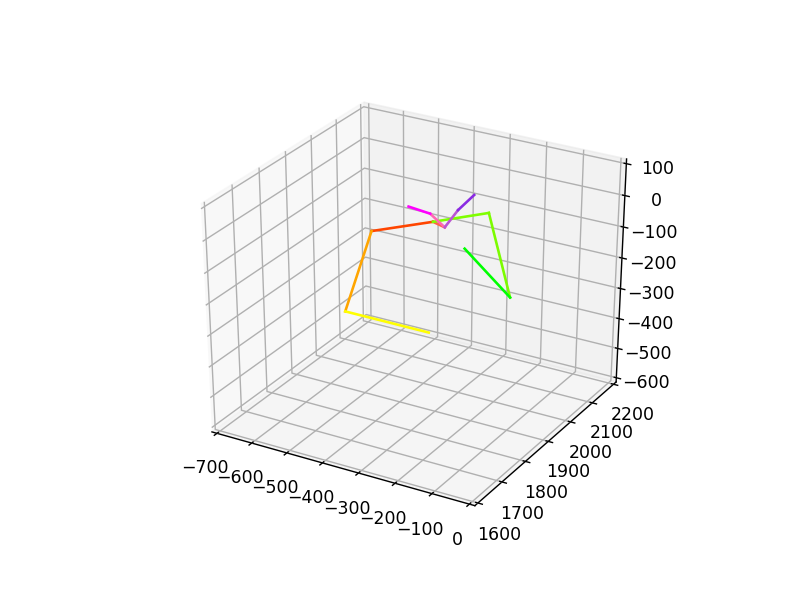

In [13]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, aspect='equal', projection = '3d')
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(number_frames):
    ax.clear()
    
    ax.set_xlim3d(-700, 0)
    ax.set_ylim3d(1600,2200)
    ax.set_zlim3d(-600,100)
    
    list_points=weighted_mean_points_3D[i]
    
    zero = list_points[0]; one = list_points[1]; two = list_points[2]; three = list_points[3]; four = list_points[4]
    five = list_points[5]; six = list_points[6]; seven = list_points[7]; eight = list_points[8]; nine = list_points[9]
    ten = list_points[10]; eleven = list_points[11]; twelve = list_points[12]; thirteen = list_points[13] 
    fourteen = list_points[14]; fifteen = list_points[15]; sixteen = list_points[16]; seventeen = list_points[17] 
    eighteen = list_points[18]; nineteen = list_points[19]; twenty = list_points[20]; twentyone = list_points[21] 
    twentytwo = list_points[22]; twentythree = list_points[23]; twentyfour = list_points[24]
    
    # 0, 1
    if zero.any() != 0 and one.any():
        x = [zero[0], one[0]]
        y = [-zero[1], -one[1]]
        z = [zero[2], one[2]]
        ax.plot(x, z, y, color = 'tomato')
    
    # 1, 2
    if one.any() != 0 and two.any() != 0:
        x = [one[0], two[0]]
        y = [-one[1], -two[1]]
        z = [one[2], two[2]]
        ax.plot(x, z, y, color = 'orangered')
    
    # 2, 3
    if two.any() != 0 and three.any() != 0:
        x = [two[0], three[0]]
        y = [-two[1], -three[1]]
        z = [two[2], three[2]]
        ax.plot(x, z, y, color = 'orange')
        
    # 3, 4
    if three.any() != 0 and four.any() != 0:
        x = [three[0], four[0]]
        y = [-three[1], -four[1]]
        z = [three[2], four[2]]
        ax.plot(x, z, y, color = 'yellow')
        
    # 1, 5
    if one.any() != 0 and five.any() != 0:
        x = [one[0], five[0]]
        y = [-one[1], -five[1]]
        z = [one[2], five[2]]
        ax.plot(x, z, y, color = 'chartreuse')
        
    # 5, 6
    if five.any() != 0 and six.any() != 0:
        x = [five[0], six[0]]
        y = [-five[1], -six[1]]
        z = [five[2], six[2]]
        ax.plot(x, z, y, color = 'lawngreen')
    
    # 6, 7
    if six.any() != 0 and seven.any() != 0:
        x = [six[0], seven[0]]
        y = [-six[1], -seven[1]]
        z = [six[2], seven[2]]
        ax.plot(x, z, y, color = 'lime')
        
    # 1, 8
    if one.any() != 0 and eight.any() != 0:
        x = [one[0], eight[0]]
        y = [-one[1], -eight[1]]
        z = [one[2], eight[2]]
        ax.plot(x, z, y, color = 'red')
        
    # 8, 9
    if eight.any() != 0 and nine.any() != 0:
        x = [eight[0], nine[0]]
        y = [-eight[1], -nine[1]]
        z = [eight[2], nine[2]]
        ax.plot(x, z, y, color = 'limegreen')
        
    # 9, 10
    if nine.any() != 0 and ten.any () != 0:
        x = [nine[0], ten[0]]
        y = [-nine[1], -ten[1]]
        z = [nine[2], ten[2]]
        ax.plot(x, z, y, color = 'springgreen')
        
    # 10, 11
    if ten.any() != 0 and eleven.any() != 0:
        x = [ten[0], eleven[0]]
        y = [-ten[1], -eleven[1]]
        z = [ten[2], eleven[2]]
        ax.plot(x, z, y, color = 'cyan')
        
    # 11, 22
    if eleven.any() != 0 and twentytwo.any() != 0:
        x = [eleven[0], twentytwo[0]]
        y = [-eleven[1], -twentytwo[1]]
        z = [eleven[2], twentytwo[2]]
        ax.plot(x, z, y, color = 'cyan')
    
    # 11, 24
    if eleven.any() != 0 and twentyfour.any() != 0:
        x = [eleven[0], twentyfour[0]]
        y = [-eleven[1], -twentyfour[1]]
        z = [eleven[2], twentyfour[2]]
        ax.plot(x, z, y, color = 'cyan')
    
    # 22, 23
    if twentytwo.any() != 0 and twentythree.any() != 0:
        x = [twentytwo[0], twentythree[0]]
        y = [-twentytwo[1], -twentythree[1]]
        z = [twentytwo[2], twentythree[2]]
        ax.plot(x, z, y, color = 'cyan')
    
    # 8, 12
    if eight.any() != 0 and twelve.any() != 0:
        x = [eight[0], twelve[0]]
        y = [-eight[1], -twelve[1]]
        z = [eight[2], twelve[2]]
        ax.plot(x, z, y, color = 'cornflowerblue')
    
    # 12, 13
    if twelve.any() != 0 and thirteen.any() != 0:
        x = [twelve[0], thirteen[0]]
        y = [-twelve[1], -thirteen[1]]
        z = [twelve[2], thirteen[2]]
        ax.plot(x, z, y, color = 'royalblue')
    
    # 13, 14
    if thirteen.any() != 0 and fourteen.any() != 0:
        x = [thirteen[0], fourteen[0]]
        y = [-thirteen[1], -fourteen[1]]
        z = [thirteen[2], fourteen[2]]
        ax.plot(x, z, y, color = 'blue')
    
    # 14, 19
    if fourteen.any() != 0 and nineteen.any() != 0:
        x = [fourteen[0], nineteen[0]]
        y = [-fourteen[1], -nineteen[1]]
        z = [fourteen[2], nineteen[2]]
        ax.plot(x, z, y, color = 'blue')
    
    # 14, 21
    if fourteen.any() != 0 and twentyone.any() != 0:
        x = [fourteen[0], twentyone[0]]
        y = [-fourteen[1], -twentyone[1]]
        z = [fourteen[2], twentyone[2]]
        ax.plot(x, z, y, color = 'blue')
    
    # 19, 20
    if nineteen.any() != 0 and twenty.any() != 0:
        x = [nineteen[0], twenty[0]]
        y = [-nineteen[1], -twenty[1]]
        z = [nineteen[2], twenty[2]]
        ax.plot(x, z, y, color = 'blue')
        
    # 0, 15
    if zero.any() != 0 and fifteen.any() != 0:
        x = [zero[0], fifteen[0]]
        y = [-zero[1], -fifteen[1]]
        z = [zero[2], fifteen[2]]
        ax.plot(x, z, y, color = 'hotpink')
    
    # 0, 16
    if zero.any() != 0 and sixteen.any() != 0:
        x = [zero[0], sixteen[0]]
        y = [-zero[1], -sixteen[1]]
        z = [zero[2], sixteen[2]]
        ax.plot(x, z, y, color = 'mediumorchid')
    
    # 15, 17
    if fifteen.any() != 0 and seventeen.any() != 0:
        x = [fifteen[0], seventeen[0]]
        y = [-fifteen[1], -seventeen[1]]
        z = [fifteen[2], seventeen[2]]
        ax.plot(x, z, y, color = 'magenta')
        
    # 16, 18
    if sixteen.any() != 0 and eighteen.any() != 0:
        x = [sixteen[0], eighteen[0]]
        y = [-sixteen[1], -eighteen[1]]
        z = [sixteen[2], eighteen[2]]
        ax.plot(x, z, y, color = 'blueviolet')
    
    fig.canvas.draw()